In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/stud.csv')

In [3]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Seperando as variáveis X e Y

In [4]:
X = df.drop(columns=['math_score'],axis=1)
X.head(3)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93


In [5]:
y = df['math_score']

In [6]:
# guardando as variáveis numéricas de X
num_features = X.select_dtypes(exclude='object')
# guardando as variáveis categóricas de X
cat_features = X.select_dtypes(include="object")

## Featuring Encoder

Aplicando OneHotEncoder sobre as variáveis categóricas de X

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# encoder
enc = OneHotEncoder(handle_unknown='ignore',drop='first')
# aplicando o encoder
cat_features = enc.fit_transform(cat_features).toarray()

In [8]:
X_encoded = pd.DataFrame(cat_features) # transformando em DataFrame
X_encoded.columns = enc.get_feature_names_out() # renomeando as colunas

In [9]:
X_encoded.head(3)

,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school,lunch_standard,test_preparation_course_none
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


Unindo as variávies já codificadas com as variáveis numéricas de X

In [10]:
X_all = pd.concat([X_encoded,num_features],axis=1) # concatenando os dataframes
X_all.head()

,gender_male,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school,lunch_standard,test_preparation_course_none,reading_score,writing_score
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,72,74
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,90,88
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,95,93
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57,44
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,78,75


## Separando em treino e teste

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 14), (200, 14))

## Featuring Scaling
Agora que dividimos em treino e teste, poderemos aplicar o StandarScaler sobre as variáveis numéricas de X_train e depois usar
este scaler no X_test

In [12]:
scaler = StandardScaler()

In [56]:
X_train[['reading_score','writing_score']] = scaler.fit_transform(X_train[['reading_score','writing_score']])
X_test[['reading_score','writing_score']] = scaler.transform(X_test[['reading_score','writing_score']])

In [65]:
linear_regression_params = {
    'fit_intercept': [True, False]
}
ridge_regression_params = {
    'alpha': np.logspace(-3, 3, 20),
    'random_state': [42]
}
catboost_regressor_params = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'random_state': [42]
}
adaboost_regressor_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'random_state': [42]
}
random_forest_regressor_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'random_state': [42]
}
lasso_regression_params = {
    'alpha': np.logspace(-3, 3, 20),
    'random_state': [42]
}
xgb_regressor_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'random_state': [42]
}
kneighbors_regressor_params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}

In [39]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
def evaluate_models(X_train, y_train,X_test,y_test,models):
        report = {}
    
        for i in range(len(list(models))):
            model = list(models.values())[i]
            para=param[list(models.keys())[i]]

            gs = GridSearchCV(model,para,cv=3)
            gs.fit(X_train,y_train)

            model.set_params(**gs.best_params_)
            model.fit(X_train,y_train)

            #model.fit(X_train, y_train)  # Train model

            y_train_pred = model.predict(X_train)

            y_test_pred = model.predict(X_test)

            train_model_score = r2_score(y_train, y_train_pred)

            test_model_score = r2_score(y_test, y_test_pred)

            report[list(models.keys())[i]] = test_model_score

        return report

In [ ]:
evaluate_models(X_train,y_train,X_test,y_test,models,)

In [66]:
# Criando o dicionário de modelos
models = {
    "Linear Regression": {
        "model_name": LinearRegression(),
        "params": linear_regression_params
    },
    "Ridge Regression": {
        "model_name": Ridge(),
        "params": ridge_regression_params
    },
    "CatBoost Regressor": {
        "model_name": CatBoostRegressor(),
        "params": catboost_regressor_params
    },
    "AdaBoost Regressor": {
        "model_name": AdaBoostRegressor(),
        "params": adaboost_regressor_params
    },
    "Random Forest Regressor": {
        "model_name": RandomForestRegressor(),
        "params": random_forest_regressor_params
    },
    "Lasso Regression": {
        "model_name": Lasso(),
        "params": lasso_regression_params
    },
    "XGBoost Regressor": {
        "model_name": XGBRegressor(),
        "params": xgb_regressor_params
    },
    "K-Neighbors Regressor": {
        "model_name": KNeighborsRegressor(),
        "params": kneighbors_regressor_params
    }
}

In [ ]:
model_list = []
r2_list =[]

In [63]:
def serch_for_best_params(classifiers, x, y,scoring='r2', cv=10, n_iter=10):

  for model_name, model_attributes in classifiers.items():

        rnd_search = RandomizedSearchCV(model_attributes['model_name'], model_attributes['params'], 
                                                        scoring=scoring, cv=cv,
                                                random_state=42, n_iter=n_iter)
        rnd_search.fit(x, y)

        col_names = [x for x,i in rnd_search.best_params_.items()]

        results = pd.DataFrame(rnd_search.best_params_, columns=col_names, index=[0])
        print(f'Para {model_name}:')
        print(f' Best score:{rnd_search.best_score_}')
        display(results)

In [69]:
serch_for_best_params(models, X_train, y_train)

Para Linear Regression:
 Best score:0.8662088212991715


,fit_intercept
0,True


Para Ridge Regression:
 Best score:0.8662350372494718


,random_state,alpha
0,42,0.335982


0:	learn: 13.0439348	total: 521us	remaining: 51.6ms
1:	learn: 11.7202541	total: 1.41ms	remaining: 69.3ms
2:	learn: 10.4280936	total: 2.02ms	remaining: 65.3ms
3:	learn: 9.3445925	total: 2.62ms	remaining: 62.9ms
4:	learn: 8.5123202	total: 3.36ms	remaining: 63.9ms
5:	learn: 7.8369726	total: 3.97ms	remaining: 62.2ms
6:	learn: 7.3290834	total: 4.56ms	remaining: 60.6ms
7:	learn: 6.8714935	total: 5.23ms	remaining: 60.2ms
8:	learn: 6.5069641	total: 5.81ms	remaining: 58.8ms
9:	learn: 6.2074139	total: 6.41ms	remaining: 57.7ms
10:	learn: 5.9614068	total: 7ms	remaining: 56.6ms
11:	learn: 5.7840875	total: 7.57ms	remaining: 55.5ms
12:	learn: 5.6430284	total: 8.19ms	remaining: 54.8ms
13:	learn: 5.5078054	total: 8.84ms	remaining: 54.3ms
14:	learn: 5.4095387	total: 9.3ms	remaining: 52.7ms
15:	learn: 5.2944630	total: 10ms	remaining: 52.6ms
16:	learn: 5.1901995	total: 10.8ms	remaining: 52.5ms
17:	learn: 5.0956476	total: 11.3ms	remaining: 51.5ms
18:	learn: 5.0383836	total: 12ms	remaining: 51ms
19:	learn: 

24:	learn: 4.7644392	total: 14.5ms	remaining: 43.4ms
25:	learn: 4.7318572	total: 15.2ms	remaining: 43.4ms
26:	learn: 4.6916449	total: 15.9ms	remaining: 43ms
27:	learn: 4.6726034	total: 16.4ms	remaining: 42.1ms
28:	learn: 4.6579970	total: 16.6ms	remaining: 40.7ms
29:	learn: 4.6270406	total: 17.3ms	remaining: 40.4ms
30:	learn: 4.5945169	total: 18ms	remaining: 40ms
31:	learn: 4.5434788	total: 18.6ms	remaining: 39.6ms
32:	learn: 4.5158878	total: 19.3ms	remaining: 39.1ms
33:	learn: 4.4861621	total: 19.9ms	remaining: 38.6ms
34:	learn: 4.4824970	total: 20.1ms	remaining: 37.4ms
35:	learn: 4.4560244	total: 20.8ms	remaining: 37ms
36:	learn: 4.4377539	total: 21.4ms	remaining: 36.5ms
37:	learn: 4.4094926	total: 22.1ms	remaining: 36ms
38:	learn: 4.3825477	total: 22.9ms	remaining: 35.8ms
39:	learn: 4.3807805	total: 23.1ms	remaining: 34.6ms
40:	learn: 4.3577714	total: 23.6ms	remaining: 34ms
41:	learn: 4.3266615	total: 24.8ms	remaining: 34.3ms
42:	learn: 4.2986577	total: 25.6ms	remaining: 34ms
43:	lea

52:	learn: 4.0521430	total: 34ms	remaining: 30.2ms
53:	learn: 4.0335468	total: 34.9ms	remaining: 29.7ms
54:	learn: 3.9849940	total: 35.6ms	remaining: 29.1ms
55:	learn: 3.9553334	total: 36.3ms	remaining: 28.5ms
56:	learn: 3.9525479	total: 36.9ms	remaining: 27.9ms
57:	learn: 3.9338360	total: 37.5ms	remaining: 27.1ms
58:	learn: 3.9125575	total: 38ms	remaining: 26.4ms
59:	learn: 3.8895771	total: 38.6ms	remaining: 25.7ms
60:	learn: 3.8748646	total: 39.1ms	remaining: 25ms
61:	learn: 3.8587957	total: 39.7ms	remaining: 24.3ms
62:	learn: 3.8366053	total: 40.2ms	remaining: 23.6ms
63:	learn: 3.8270983	total: 40.9ms	remaining: 23ms
64:	learn: 3.8242946	total: 41.7ms	remaining: 22.4ms
65:	learn: 3.7849560	total: 42.3ms	remaining: 21.8ms
66:	learn: 3.7696983	total: 42.9ms	remaining: 21.1ms
67:	learn: 3.7456205	total: 46ms	remaining: 21.6ms
68:	learn: 3.7247077	total: 46.9ms	remaining: 21ms
69:	learn: 3.6866906	total: 47.5ms	remaining: 20.4ms
70:	learn: 3.6724102	total: 49.6ms	remaining: 20.3ms
71:	l

65:	learn: 3.7817299	total: 43.3ms	remaining: 22.3ms
66:	learn: 3.7788649	total: 43.9ms	remaining: 21.6ms
67:	learn: 3.7676765	total: 45.7ms	remaining: 21.5ms
68:	learn: 3.7481289	total: 46.3ms	remaining: 20.8ms
69:	learn: 3.7375127	total: 46.8ms	remaining: 20.1ms
70:	learn: 3.7274371	total: 47.4ms	remaining: 19.3ms
71:	learn: 3.6869528	total: 48.3ms	remaining: 18.8ms
72:	learn: 3.6528017	total: 49ms	remaining: 18.1ms
73:	learn: 3.6226086	total: 49.6ms	remaining: 17.4ms
74:	learn: 3.5896019	total: 50.2ms	remaining: 16.7ms
75:	learn: 3.5741877	total: 50.8ms	remaining: 16.1ms
76:	learn: 3.5663440	total: 51.4ms	remaining: 15.4ms
77:	learn: 3.5577954	total: 52ms	remaining: 14.7ms
78:	learn: 3.5259712	total: 52.6ms	remaining: 14ms
79:	learn: 3.5174336	total: 53.2ms	remaining: 13.3ms
80:	learn: 3.5107450	total: 53.8ms	remaining: 12.6ms
81:	learn: 3.4920679	total: 54.4ms	remaining: 11.9ms
82:	learn: 3.4643827	total: 55.2ms	remaining: 11.3ms
83:	learn: 3.4462396	total: 55.8ms	remaining: 10.6ms

93:	learn: 3.2342057	total: 55.4ms	remaining: 3.53ms
94:	learn: 3.1921449	total: 55.9ms	remaining: 2.94ms
95:	learn: 3.1898774	total: 56.7ms	remaining: 2.36ms
96:	learn: 3.1883746	total: 57.4ms	remaining: 1.77ms
97:	learn: 3.1804484	total: 58.1ms	remaining: 1.19ms
98:	learn: 3.1783521	total: 58.7ms	remaining: 592us
99:	learn: 3.1631532	total: 59.2ms	remaining: 0us
0:	learn: 12.9721987	total: 562us	remaining: 55.7ms
1:	learn: 11.4163220	total: 1.48ms	remaining: 72.4ms
2:	learn: 10.1509468	total: 2.07ms	remaining: 67.1ms
3:	learn: 9.1496269	total: 2.51ms	remaining: 60.3ms
4:	learn: 8.3206658	total: 3.1ms	remaining: 58.9ms
5:	learn: 7.7350106	total: 3.66ms	remaining: 57.4ms
6:	learn: 7.3042044	total: 3.98ms	remaining: 52.9ms
7:	learn: 6.8796756	total: 4.52ms	remaining: 52ms
8:	learn: 6.5314693	total: 5.07ms	remaining: 51.2ms
9:	learn: 6.2524696	total: 5.59ms	remaining: 50.3ms
10:	learn: 6.0221144	total: 6.12ms	remaining: 49.5ms
11:	learn: 5.8327619	total: 6.71ms	remaining: 49.2ms
12:	lear

0:	learn: 14.1703853	total: 308us	remaining: 30.6ms
1:	learn: 13.4643882	total: 821us	remaining: 40.2ms
2:	learn: 12.7116572	total: 1.05ms	remaining: 34.1ms
3:	learn: 12.0802352	total: 1.29ms	remaining: 30.9ms
4:	learn: 11.5816969	total: 1.5ms	remaining: 28.5ms
5:	learn: 10.9737992	total: 1.72ms	remaining: 26.9ms
6:	learn: 10.4234288	total: 2.07ms	remaining: 27.5ms
7:	learn: 9.9552980	total: 2.29ms	remaining: 26.3ms
8:	learn: 9.5259950	total: 2.51ms	remaining: 25.4ms
9:	learn: 9.1967967	total: 3.31ms	remaining: 29.8ms
10:	learn: 8.8037251	total: 3.54ms	remaining: 28.6ms
11:	learn: 8.5263094	total: 3.77ms	remaining: 27.7ms
12:	learn: 8.2521991	total: 3.99ms	remaining: 26.7ms
13:	learn: 7.9987887	total: 4.21ms	remaining: 25.9ms
14:	learn: 7.7696823	total: 4.43ms	remaining: 25.1ms
15:	learn: 7.6234870	total: 4.64ms	remaining: 24.4ms
16:	learn: 7.4505043	total: 4.86ms	remaining: 23.7ms
17:	learn: 7.2602008	total: 5.07ms	remaining: 23.1ms
18:	learn: 7.1088146	total: 5.29ms	remaining: 22.6ms

0:	learn: 14.1917465	total: 319us	remaining: 31.6ms
1:	learn: 13.5807909	total: 602us	remaining: 29.5ms
2:	learn: 12.7974545	total: 842us	remaining: 27.2ms
3:	learn: 12.0989193	total: 1.23ms	remaining: 29.6ms
4:	learn: 11.5444766	total: 1.52ms	remaining: 28.9ms
5:	learn: 10.9294815	total: 1.79ms	remaining: 28.1ms
6:	learn: 10.5158991	total: 2ms	remaining: 26.6ms
7:	learn: 10.0338204	total: 2.26ms	remaining: 26ms
8:	learn: 9.6698244	total: 3.77ms	remaining: 38.1ms
9:	learn: 9.2863652	total: 4.01ms	remaining: 36.1ms
10:	learn: 8.9741850	total: 4.24ms	remaining: 34.3ms
11:	learn: 8.6564559	total: 4.48ms	remaining: 32.9ms
12:	learn: 8.4040435	total: 4.69ms	remaining: 31.4ms
13:	learn: 8.1301648	total: 4.9ms	remaining: 30.1ms
14:	learn: 7.8648293	total: 5.09ms	remaining: 28.8ms
15:	learn: 7.6474707	total: 5.3ms	remaining: 27.8ms
16:	learn: 7.4475096	total: 5.51ms	remaining: 26.9ms
17:	learn: 7.2711802	total: 5.69ms	remaining: 25.9ms
18:	learn: 7.1178988	total: 5.9ms	remaining: 25.2ms
19:	le

13:	learn: 7.7860078	total: 3.86ms	remaining: 23.7ms
14:	learn: 7.5532916	total: 4.08ms	remaining: 23.1ms
15:	learn: 7.3540990	total: 4.31ms	remaining: 22.6ms
16:	learn: 7.1691711	total: 4.53ms	remaining: 22.1ms
17:	learn: 7.0333974	total: 4.75ms	remaining: 21.6ms
18:	learn: 6.8361081	total: 4.97ms	remaining: 21.2ms
19:	learn: 6.7178648	total: 5.19ms	remaining: 20.7ms
20:	learn: 6.5799917	total: 5.4ms	remaining: 20.3ms
21:	learn: 6.4598818	total: 6.81ms	remaining: 24.2ms
22:	learn: 6.3629327	total: 7.03ms	remaining: 23.5ms
23:	learn: 6.2578481	total: 7.25ms	remaining: 23ms
24:	learn: 6.1891532	total: 7.45ms	remaining: 22.4ms
25:	learn: 6.1032027	total: 7.66ms	remaining: 21.8ms
26:	learn: 6.0367805	total: 7.87ms	remaining: 21.3ms
27:	learn: 5.9726252	total: 8.08ms	remaining: 20.8ms
28:	learn: 5.9165605	total: 8.29ms	remaining: 20.3ms
29:	learn: 5.8693762	total: 8.49ms	remaining: 19.8ms
30:	learn: 5.8245856	total: 8.7ms	remaining: 19.4ms
31:	learn: 5.7819027	total: 8.9ms	remaining: 18.9m

37:	learn: 5.5656422	total: 11.1ms	remaining: 18.2ms
38:	learn: 5.5447256	total: 11.6ms	remaining: 18.2ms
39:	learn: 5.5200969	total: 11.9ms	remaining: 17.8ms
40:	learn: 5.5008636	total: 12.2ms	remaining: 17.5ms
41:	learn: 5.4853000	total: 12.8ms	remaining: 17.6ms
42:	learn: 5.4593080	total: 13.2ms	remaining: 17.5ms
43:	learn: 5.4382950	total: 13.5ms	remaining: 17.2ms
44:	learn: 5.4236422	total: 14.2ms	remaining: 17.4ms
45:	learn: 5.4093494	total: 14.9ms	remaining: 17.5ms
46:	learn: 5.3900404	total: 15.6ms	remaining: 17.5ms
47:	learn: 5.3736413	total: 16.3ms	remaining: 17.6ms
48:	learn: 5.3610985	total: 16.8ms	remaining: 17.5ms
49:	learn: 5.3485910	total: 17.3ms	remaining: 17.3ms
50:	learn: 5.3366999	total: 17.8ms	remaining: 17.1ms
51:	learn: 5.3251098	total: 18.6ms	remaining: 17.2ms
52:	learn: 5.3153997	total: 18.8ms	remaining: 16.7ms
53:	learn: 5.3023216	total: 19.1ms	remaining: 16.3ms
54:	learn: 5.2916693	total: 19.4ms	remaining: 15.8ms
55:	learn: 5.2893315	total: 19.5ms	remaining: 

40:	learn: 5.5925733	total: 9.98ms	remaining: 14.4ms
41:	learn: 5.5711685	total: 10.2ms	remaining: 14.1ms
42:	learn: 5.5523057	total: 10.4ms	remaining: 13.8ms
43:	learn: 5.5283543	total: 10.6ms	remaining: 13.5ms
44:	learn: 5.5074319	total: 10.8ms	remaining: 13.2ms
45:	learn: 5.4941408	total: 11ms	remaining: 13ms
46:	learn: 5.4814994	total: 11.3ms	remaining: 12.7ms
47:	learn: 5.4641145	total: 11.5ms	remaining: 12.4ms
48:	learn: 5.4516891	total: 11.7ms	remaining: 12.2ms
49:	learn: 5.4385892	total: 11.9ms	remaining: 11.9ms
50:	learn: 5.4259360	total: 12.1ms	remaining: 11.6ms
51:	learn: 5.4178435	total: 12.3ms	remaining: 11.4ms
52:	learn: 5.4042095	total: 12.6ms	remaining: 11.2ms
53:	learn: 5.3943062	total: 12.8ms	remaining: 10.9ms
54:	learn: 5.3884262	total: 13ms	remaining: 10.7ms
55:	learn: 5.3863041	total: 13.4ms	remaining: 10.5ms
56:	learn: 5.3738153	total: 13.6ms	remaining: 10.3ms
57:	learn: 5.3607348	total: 13.8ms	remaining: 10ms
58:	learn: 5.3546404	total: 14.1ms	remaining: 9.77ms
5

33:	learn: 4.8349478	total: 19.8ms	remaining: 38.4ms
34:	learn: 4.8176664	total: 21.7ms	remaining: 40.3ms
35:	learn: 4.7947129	total: 22.3ms	remaining: 39.6ms
36:	learn: 4.7670342	total: 24.7ms	remaining: 42ms
37:	learn: 4.7397375	total: 25.5ms	remaining: 41.5ms
38:	learn: 4.7151870	total: 26.1ms	remaining: 40.8ms
39:	learn: 4.6992636	total: 26.7ms	remaining: 40.1ms
40:	learn: 4.6760554	total: 27.3ms	remaining: 39.3ms
41:	learn: 4.6620744	total: 28ms	remaining: 38.6ms
42:	learn: 4.6373203	total: 28.6ms	remaining: 37.9ms
43:	learn: 4.6218491	total: 29.2ms	remaining: 37.1ms
44:	learn: 4.6026935	total: 29.7ms	remaining: 36.3ms
45:	learn: 4.5855794	total: 30.3ms	remaining: 35.5ms
46:	learn: 4.5611307	total: 31.1ms	remaining: 35.1ms
47:	learn: 4.5402496	total: 31.8ms	remaining: 34.5ms
48:	learn: 4.5246525	total: 32.5ms	remaining: 33.8ms
49:	learn: 4.4887519	total: 33.2ms	remaining: 33.2ms
50:	learn: 4.4777873	total: 33.8ms	remaining: 32.5ms
51:	learn: 4.4588791	total: 34.5ms	remaining: 31.8

66:	learn: 4.2766180	total: 41.4ms	remaining: 20.4ms
67:	learn: 4.2481335	total: 42.2ms	remaining: 19.9ms
68:	learn: 4.2138703	total: 42.8ms	remaining: 19.2ms
69:	learn: 4.2007313	total: 44.4ms	remaining: 19ms
70:	learn: 4.1741316	total: 47.8ms	remaining: 19.5ms
71:	learn: 4.1739679	total: 48.2ms	remaining: 18.8ms
72:	learn: 4.1722998	total: 48.9ms	remaining: 18.1ms
73:	learn: 4.1546006	total: 49.6ms	remaining: 17.4ms
74:	learn: 4.1356707	total: 50.3ms	remaining: 16.8ms
75:	learn: 4.1206633	total: 51ms	remaining: 16.1ms
76:	learn: 4.1205264	total: 51.1ms	remaining: 15.3ms
77:	learn: 4.0984784	total: 52.6ms	remaining: 14.8ms
78:	learn: 4.0954391	total: 53.9ms	remaining: 14.3ms
79:	learn: 4.0791891	total: 55.1ms	remaining: 13.8ms
80:	learn: 4.0699579	total: 56.3ms	remaining: 13.2ms
81:	learn: 4.0480825	total: 57.7ms	remaining: 12.7ms
82:	learn: 4.0310046	total: 58.9ms	remaining: 12.1ms
83:	learn: 4.0178195	total: 60.3ms	remaining: 11.5ms
84:	learn: 4.0166780	total: 61.5ms	remaining: 10.9

85:	learn: 3.9358850	total: 55.9ms	remaining: 9.1ms
86:	learn: 3.9147424	total: 56.8ms	remaining: 8.49ms
87:	learn: 3.8851505	total: 57.5ms	remaining: 7.83ms
88:	learn: 3.8722040	total: 58.5ms	remaining: 7.22ms
89:	learn: 3.8658300	total: 59.2ms	remaining: 6.57ms
90:	learn: 3.8434541	total: 60.5ms	remaining: 5.98ms
91:	learn: 3.8259849	total: 61.8ms	remaining: 5.37ms
92:	learn: 3.8220212	total: 62.4ms	remaining: 4.69ms
93:	learn: 3.8101974	total: 62.9ms	remaining: 4.02ms
94:	learn: 3.7974163	total: 63.5ms	remaining: 3.34ms
95:	learn: 3.7948377	total: 64ms	remaining: 2.67ms
96:	learn: 3.7832236	total: 64.6ms	remaining: 2ms
97:	learn: 3.7590795	total: 65.1ms	remaining: 1.33ms
98:	learn: 3.7352768	total: 65.7ms	remaining: 663us
99:	learn: 3.7264530	total: 66.2ms	remaining: 0us
0:	learn: 13.2056540	total: 422us	remaining: 41.8ms
1:	learn: 11.9048551	total: 1ms	remaining: 49.3ms
2:	learn: 10.8289572	total: 1.57ms	remaining: 51ms
3:	learn: 9.8101981	total: 2.16ms	remaining: 51.9ms
4:	learn: 

94:	learn: 3.9512837	total: 75.7ms	remaining: 3.99ms
95:	learn: 3.9347539	total: 77.1ms	remaining: 3.21ms
96:	learn: 3.9181339	total: 78.7ms	remaining: 2.43ms
97:	learn: 3.8974343	total: 79.5ms	remaining: 1.62ms
98:	learn: 3.8964889	total: 80.1ms	remaining: 808us
99:	learn: 3.8889376	total: 80.7ms	remaining: 0us
0:	learn: 13.3378573	total: 477us	remaining: 47.3ms
1:	learn: 11.9960042	total: 1.08ms	remaining: 53.1ms
2:	learn: 10.7042100	total: 1.5ms	remaining: 48.5ms
3:	learn: 9.7068693	total: 2.13ms	remaining: 51.1ms
4:	learn: 8.8865443	total: 2.5ms	remaining: 47.5ms
5:	learn: 8.2526802	total: 3.16ms	remaining: 49.5ms
6:	learn: 7.7352778	total: 4.74ms	remaining: 63ms
7:	learn: 7.3396923	total: 5.36ms	remaining: 61.7ms
8:	learn: 6.9944556	total: 5.91ms	remaining: 59.7ms
9:	learn: 6.6662732	total: 6.58ms	remaining: 59.2ms
10:	learn: 6.4237325	total: 7.7ms	remaining: 62.3ms
11:	learn: 6.2385620	total: 8.31ms	remaining: 61ms
12:	learn: 6.0668362	total: 8.76ms	remaining: 58.6ms
13:	learn: 5

87:	learn: 3.9332843	total: 52ms	remaining: 7.09ms
88:	learn: 3.9093435	total: 52.9ms	remaining: 6.53ms
89:	learn: 3.8991702	total: 53.6ms	remaining: 5.96ms
90:	learn: 3.8889465	total: 55.4ms	remaining: 5.47ms
91:	learn: 3.8697466	total: 56.5ms	remaining: 4.91ms
92:	learn: 3.8527621	total: 57.2ms	remaining: 4.3ms
93:	learn: 3.8373351	total: 57.8ms	remaining: 3.69ms
94:	learn: 3.8175252	total: 58.3ms	remaining: 3.07ms
95:	learn: 3.8046197	total: 59ms	remaining: 2.46ms
96:	learn: 3.7917882	total: 59.5ms	remaining: 1.84ms
97:	learn: 3.7772479	total: 60.1ms	remaining: 1.23ms
98:	learn: 3.7478430	total: 60.6ms	remaining: 611us
99:	learn: 3.7378176	total: 61.1ms	remaining: 0us
0:	learn: 12.9137181	total: 496us	remaining: 148ms
1:	learn: 11.2847539	total: 853us	remaining: 127ms
2:	learn: 9.9672912	total: 1.17ms	remaining: 116ms
3:	learn: 8.9890155	total: 1.43ms	remaining: 106ms
4:	learn: 8.2004052	total: 1.77ms	remaining: 104ms
5:	learn: 7.5230768	total: 2.09ms	remaining: 102ms
6:	learn: 6.99

72:	learn: 3.9522674	total: 29.1ms	remaining: 90.6ms
73:	learn: 3.9436056	total: 29.6ms	remaining: 90.3ms
74:	learn: 3.9159452	total: 30ms	remaining: 90ms
75:	learn: 3.8973347	total: 30.3ms	remaining: 89.4ms
76:	learn: 3.8840355	total: 30.8ms	remaining: 89.1ms
77:	learn: 3.8797940	total: 32.9ms	remaining: 93.8ms
78:	learn: 3.8634310	total: 33.5ms	remaining: 93.8ms
79:	learn: 3.8519749	total: 33.9ms	remaining: 93.1ms
80:	learn: 3.8113829	total: 34.2ms	remaining: 92.4ms
81:	learn: 3.7905502	total: 34.6ms	remaining: 91.9ms
82:	learn: 3.7829575	total: 34.9ms	remaining: 91.3ms
83:	learn: 3.7814919	total: 35.3ms	remaining: 90.6ms
84:	learn: 3.7656630	total: 35.6ms	remaining: 90.1ms
85:	learn: 3.7547583	total: 35.9ms	remaining: 89.4ms
86:	learn: 3.7380388	total: 36.2ms	remaining: 88.7ms
87:	learn: 3.7320972	total: 36.5ms	remaining: 88ms
88:	learn: 3.7082755	total: 36.8ms	remaining: 87.3ms
89:	learn: 3.6986675	total: 37.1ms	remaining: 86.7ms
90:	learn: 3.6700496	total: 37.4ms	remaining: 85.9ms

212:	learn: 2.3273297	total: 69.2ms	remaining: 28.3ms
213:	learn: 2.3234304	total: 69.9ms	remaining: 28.1ms
214:	learn: 2.3088278	total: 70.3ms	remaining: 27.8ms
215:	learn: 2.2945572	total: 70.7ms	remaining: 27.5ms
216:	learn: 2.2891967	total: 71ms	remaining: 27.2ms
217:	learn: 2.2861121	total: 71.3ms	remaining: 26.8ms
218:	learn: 2.2742824	total: 71.6ms	remaining: 26.5ms
219:	learn: 2.2682520	total: 71.9ms	remaining: 26.1ms
220:	learn: 2.2592062	total: 72.3ms	remaining: 25.9ms
221:	learn: 2.2503055	total: 73ms	remaining: 25.7ms
222:	learn: 2.2419207	total: 73.7ms	remaining: 25.5ms
223:	learn: 2.2272319	total: 74.4ms	remaining: 25.2ms
224:	learn: 2.2212847	total: 75ms	remaining: 25ms
225:	learn: 2.2168086	total: 75.7ms	remaining: 24.8ms
226:	learn: 2.2077802	total: 76.4ms	remaining: 24.6ms
227:	learn: 2.2007451	total: 77.1ms	remaining: 24.3ms
228:	learn: 2.1887367	total: 81ms	remaining: 25.1ms
229:	learn: 2.1839364	total: 82.2ms	remaining: 25ms
230:	learn: 2.1803919	total: 82.7ms	rema

264:	learn: 1.9398651	total: 94.6ms	remaining: 12.5ms
265:	learn: 1.9376968	total: 95ms	remaining: 12.1ms
266:	learn: 1.9308030	total: 95.4ms	remaining: 11.8ms
267:	learn: 1.9215588	total: 95.7ms	remaining: 11.4ms
268:	learn: 1.9178537	total: 96.1ms	remaining: 11.1ms
269:	learn: 1.9106890	total: 96.4ms	remaining: 10.7ms
270:	learn: 1.9056861	total: 96.7ms	remaining: 10.3ms
271:	learn: 1.9023829	total: 97ms	remaining: 9.98ms
272:	learn: 1.8931470	total: 97.3ms	remaining: 9.62ms
273:	learn: 1.8852829	total: 97.6ms	remaining: 9.26ms
274:	learn: 1.8797141	total: 98ms	remaining: 8.9ms
275:	learn: 1.8780706	total: 98.7ms	remaining: 8.58ms
276:	learn: 1.8742939	total: 99ms	remaining: 8.22ms
277:	learn: 1.8689639	total: 99.4ms	remaining: 7.87ms
278:	learn: 1.8632890	total: 99.9ms	remaining: 7.52ms
279:	learn: 1.8591545	total: 100ms	remaining: 7.16ms
280:	learn: 1.8584642	total: 101ms	remaining: 6.81ms
281:	learn: 1.8550568	total: 101ms	remaining: 6.48ms
282:	learn: 1.8534975	total: 102ms	remai

60:	learn: 4.0337336	total: 24.9ms	remaining: 97.4ms
61:	learn: 4.0024719	total: 25.5ms	remaining: 98ms
62:	learn: 3.9909301	total: 25.9ms	remaining: 97.5ms
63:	learn: 3.9648637	total: 26.3ms	remaining: 96.9ms
64:	learn: 3.9549896	total: 26.7ms	remaining: 96.4ms
65:	learn: 3.9391143	total: 27ms	remaining: 95.8ms
66:	learn: 3.9107629	total: 27.4ms	remaining: 95.2ms
67:	learn: 3.8829425	total: 27.7ms	remaining: 94.6ms
68:	learn: 3.8689315	total: 28.1ms	remaining: 94ms
69:	learn: 3.8555343	total: 28.4ms	remaining: 93.4ms
70:	learn: 3.8458023	total: 28.8ms	remaining: 92.8ms
71:	learn: 3.8259488	total: 29.1ms	remaining: 92.2ms
72:	learn: 3.8021994	total: 29.4ms	remaining: 91.6ms
73:	learn: 3.7907943	total: 29.8ms	remaining: 90.9ms
74:	learn: 3.7829125	total: 30.1ms	remaining: 90.3ms
75:	learn: 3.7750097	total: 30.4ms	remaining: 89.7ms
76:	learn: 3.7623248	total: 30.8ms	remaining: 89.2ms
77:	learn: 3.7473244	total: 31.1ms	remaining: 88.6ms
78:	learn: 3.7173539	total: 31.5ms	remaining: 88.1ms

184:	learn: 2.5725238	total: 68.3ms	remaining: 42.5ms
185:	learn: 2.5702393	total: 69.9ms	remaining: 42.8ms
186:	learn: 2.5559178	total: 70.4ms	remaining: 42.5ms
187:	learn: 2.5499609	total: 70.8ms	remaining: 42.2ms
188:	learn: 2.5449498	total: 71.1ms	remaining: 41.8ms
189:	learn: 2.5423997	total: 71.4ms	remaining: 41.3ms
190:	learn: 2.5249214	total: 71.7ms	remaining: 40.9ms
191:	learn: 2.5222645	total: 72ms	remaining: 40.5ms
192:	learn: 2.5177020	total: 72.3ms	remaining: 40.1ms
193:	learn: 2.5169762	total: 72.6ms	remaining: 39.7ms
194:	learn: 2.5149660	total: 72.9ms	remaining: 39.3ms
195:	learn: 2.5091240	total: 73.2ms	remaining: 38.8ms
196:	learn: 2.5047528	total: 73.5ms	remaining: 38.4ms
197:	learn: 2.5028337	total: 73.8ms	remaining: 38ms
198:	learn: 2.4885800	total: 74.1ms	remaining: 37.6ms
199:	learn: 2.4851970	total: 74.4ms	remaining: 37.2ms
200:	learn: 2.4722794	total: 74.7ms	remaining: 36.8ms
201:	learn: 2.4547030	total: 75ms	remaining: 36.4ms
202:	learn: 2.4497518	total: 75.3m

269:	learn: 1.8342466	total: 100ms	remaining: 11.1ms
270:	learn: 1.8255165	total: 101ms	remaining: 10.8ms
271:	learn: 1.8211769	total: 101ms	remaining: 10.4ms
272:	learn: 1.8172725	total: 101ms	remaining: 10ms
273:	learn: 1.8160094	total: 102ms	remaining: 9.66ms
274:	learn: 1.8136737	total: 102ms	remaining: 9.29ms
275:	learn: 1.8061055	total: 103ms	remaining: 8.91ms
276:	learn: 1.8041076	total: 103ms	remaining: 8.54ms
277:	learn: 1.7942936	total: 103ms	remaining: 8.16ms
278:	learn: 1.7914485	total: 104ms	remaining: 7.79ms
279:	learn: 1.7803881	total: 104ms	remaining: 7.42ms
280:	learn: 1.7796835	total: 104ms	remaining: 7.04ms
281:	learn: 1.7762011	total: 105ms	remaining: 6.67ms
282:	learn: 1.7739278	total: 105ms	remaining: 6.3ms
283:	learn: 1.7655491	total: 105ms	remaining: 5.93ms
284:	learn: 1.7595579	total: 106ms	remaining: 5.55ms
285:	learn: 1.7529927	total: 106ms	remaining: 5.18ms
286:	learn: 1.7523326	total: 106ms	remaining: 4.81ms
287:	learn: 1.7489700	total: 106ms	remaining: 4.4

30:	learn: 4.7851112	total: 11.3ms	remaining: 98.4ms
31:	learn: 4.7553331	total: 12.9ms	remaining: 108ms
32:	learn: 4.7297442	total: 13.6ms	remaining: 110ms
33:	learn: 4.7078146	total: 14.4ms	remaining: 112ms
34:	learn: 4.6660054	total: 15.1ms	remaining: 115ms
35:	learn: 4.6438690	total: 15.4ms	remaining: 113ms
36:	learn: 4.5999635	total: 15.8ms	remaining: 112ms
37:	learn: 4.5797799	total: 16.1ms	remaining: 111ms
38:	learn: 4.5485260	total: 16.4ms	remaining: 109ms
39:	learn: 4.5332494	total: 16.7ms	remaining: 108ms
40:	learn: 4.4978768	total: 17ms	remaining: 107ms
41:	learn: 4.4801555	total: 17.3ms	remaining: 106ms
42:	learn: 4.4725099	total: 17.6ms	remaining: 105ms
43:	learn: 4.4621981	total: 17.8ms	remaining: 104ms
44:	learn: 4.4268021	total: 18.1ms	remaining: 103ms
45:	learn: 4.4060470	total: 18.4ms	remaining: 102ms
46:	learn: 4.3717149	total: 18.7ms	remaining: 101ms
47:	learn: 4.3515275	total: 19ms	remaining: 99.9ms
48:	learn: 4.3229427	total: 19.3ms	remaining: 99ms
49:	learn: 4.29

129:	learn: 4.5331747	total: 53ms	remaining: 69.3ms
130:	learn: 4.5326601	total: 53.4ms	remaining: 68.9ms
131:	learn: 4.5262639	total: 53.9ms	remaining: 68.6ms
132:	learn: 4.5170243	total: 55ms	remaining: 69ms
133:	learn: 4.5110828	total: 55.7ms	remaining: 69ms
134:	learn: 4.5034307	total: 56.3ms	remaining: 68.9ms
135:	learn: 4.4928531	total: 57ms	remaining: 68.8ms
136:	learn: 4.4848131	total: 57.7ms	remaining: 68.7ms
137:	learn: 4.4739720	total: 58.4ms	remaining: 68.5ms
138:	learn: 4.4711213	total: 59.1ms	remaining: 68.4ms
139:	learn: 4.4638586	total: 59.4ms	remaining: 67.9ms
140:	learn: 4.4516147	total: 59.8ms	remaining: 67.5ms
141:	learn: 4.4458044	total: 60.2ms	remaining: 67ms
142:	learn: 4.4351643	total: 60.6ms	remaining: 66.5ms
143:	learn: 4.4238767	total: 60.9ms	remaining: 66ms
144:	learn: 4.4210505	total: 61.2ms	remaining: 65.5ms
145:	learn: 4.4177913	total: 61.6ms	remaining: 64.9ms
146:	learn: 4.4085011	total: 61.9ms	remaining: 64.4ms
147:	learn: 4.4080574	total: 62.2ms	remain

269:	learn: 3.7823282	total: 91.7ms	remaining: 10.2ms
270:	learn: 3.7762981	total: 92.3ms	remaining: 9.87ms
271:	learn: 3.7706089	total: 92.6ms	remaining: 9.53ms
272:	learn: 3.7650899	total: 93ms	remaining: 9.19ms
273:	learn: 3.7647809	total: 93.3ms	remaining: 8.85ms
274:	learn: 3.7615462	total: 95.4ms	remaining: 8.67ms
275:	learn: 3.7529095	total: 96.1ms	remaining: 8.36ms
276:	learn: 3.7505204	total: 96.8ms	remaining: 8.04ms
277:	learn: 3.7452362	total: 97.7ms	remaining: 7.73ms
278:	learn: 3.7403129	total: 98.4ms	remaining: 7.4ms
279:	learn: 3.7356446	total: 99.2ms	remaining: 7.09ms
280:	learn: 3.7306806	total: 100ms	remaining: 6.76ms
281:	learn: 3.7279400	total: 101ms	remaining: 6.43ms
282:	learn: 3.7245815	total: 102ms	remaining: 6.1ms
283:	learn: 3.7189902	total: 102ms	remaining: 5.76ms
284:	learn: 3.7171054	total: 103ms	remaining: 5.42ms
285:	learn: 3.7156111	total: 104ms	remaining: 5.08ms
286:	learn: 3.7091657	total: 104ms	remaining: 4.73ms
287:	learn: 3.7066290	total: 105ms	rema

22:	learn: 6.2117129	total: 8.82ms	remaining: 106ms
23:	learn: 6.1208875	total: 10.2ms	remaining: 117ms
24:	learn: 6.0400892	total: 10.6ms	remaining: 116ms
25:	learn: 5.9738028	total: 11.1ms	remaining: 117ms
26:	learn: 5.9110016	total: 11.5ms	remaining: 116ms
27:	learn: 5.8523032	total: 11.8ms	remaining: 115ms
28:	learn: 5.7942896	total: 12.2ms	remaining: 114ms
29:	learn: 5.7391266	total: 12.5ms	remaining: 113ms
30:	learn: 5.6985049	total: 12.8ms	remaining: 111ms
31:	learn: 5.6492759	total: 13.4ms	remaining: 112ms
32:	learn: 5.6042986	total: 13.7ms	remaining: 111ms
33:	learn: 5.5659494	total: 14ms	remaining: 109ms
34:	learn: 5.5292278	total: 17.4ms	remaining: 132ms
35:	learn: 5.4953337	total: 17.8ms	remaining: 131ms
36:	learn: 5.4643927	total: 18.1ms	remaining: 129ms
37:	learn: 5.4425770	total: 18.5ms	remaining: 127ms
38:	learn: 5.4174832	total: 18.8ms	remaining: 126ms
39:	learn: 5.3987008	total: 19.2ms	remaining: 125ms
40:	learn: 5.3801696	total: 19.5ms	remaining: 123ms
41:	learn: 5.3

104:	learn: 4.7368517	total: 35.2ms	remaining: 65.4ms
105:	learn: 4.7344535	total: 35.6ms	remaining: 65.2ms
106:	learn: 4.7243792	total: 36ms	remaining: 64.9ms
107:	learn: 4.7168492	total: 36.3ms	remaining: 64.6ms
108:	learn: 4.7101826	total: 36.7ms	remaining: 64.3ms
109:	learn: 4.7100342	total: 36.8ms	remaining: 63.6ms
110:	learn: 4.7052177	total: 37.2ms	remaining: 63.3ms
111:	learn: 4.6985527	total: 37.5ms	remaining: 63ms
112:	learn: 4.6979931	total: 37.9ms	remaining: 62.7ms
113:	learn: 4.6862950	total: 38.2ms	remaining: 62.4ms
114:	learn: 4.6756200	total: 38.6ms	remaining: 62.1ms
115:	learn: 4.6709915	total: 38.9ms	remaining: 61.7ms
116:	learn: 4.6702046	total: 39.3ms	remaining: 61.5ms
117:	learn: 4.6605239	total: 39.7ms	remaining: 61.2ms
118:	learn: 4.6565047	total: 40ms	remaining: 60.8ms
119:	learn: 4.6468491	total: 40.4ms	remaining: 60.5ms
120:	learn: 4.6388743	total: 40.7ms	remaining: 60.2ms
121:	learn: 4.6260556	total: 41.1ms	remaining: 59.9ms
122:	learn: 4.6111575	total: 41.4m

282:	learn: 3.6029322	total: 87.2ms	remaining: 5.24ms
283:	learn: 3.5931121	total: 87.6ms	remaining: 4.93ms
284:	learn: 3.5872118	total: 87.9ms	remaining: 4.63ms
285:	learn: 3.5868603	total: 88.3ms	remaining: 4.32ms
286:	learn: 3.5846182	total: 88.6ms	remaining: 4.01ms
287:	learn: 3.5768892	total: 89.1ms	remaining: 3.71ms
288:	learn: 3.5740880	total: 89.4ms	remaining: 3.4ms
289:	learn: 3.5732973	total: 89.7ms	remaining: 3.09ms
290:	learn: 3.5687019	total: 90.1ms	remaining: 2.79ms
291:	learn: 3.5684343	total: 90.4ms	remaining: 2.48ms
292:	learn: 3.5679799	total: 90.7ms	remaining: 2.17ms
293:	learn: 3.5620905	total: 91ms	remaining: 1.86ms
294:	learn: 3.5575657	total: 91.4ms	remaining: 1.55ms
295:	learn: 3.5501849	total: 91.7ms	remaining: 1.24ms
296:	learn: 3.5468619	total: 92.1ms	remaining: 930us
297:	learn: 3.5433096	total: 92.4ms	remaining: 620us
298:	learn: 3.5399828	total: 92.7ms	remaining: 310us
299:	learn: 3.5372213	total: 93.1ms	remaining: 0us
0:	learn: 14.1589112	total: 406us	rem

110:	learn: 4.6502463	total: 33.6ms	remaining: 57.2ms
111:	learn: 4.6494018	total: 33.9ms	remaining: 57ms
112:	learn: 4.6437797	total: 34.3ms	remaining: 56.7ms
113:	learn: 4.6320756	total: 34.6ms	remaining: 56.5ms
114:	learn: 4.6226731	total: 35ms	remaining: 56.3ms
115:	learn: 4.6151989	total: 35.3ms	remaining: 56ms
116:	learn: 4.6040045	total: 35.7ms	remaining: 55.8ms
117:	learn: 4.6032253	total: 36ms	remaining: 55.6ms
118:	learn: 4.5886227	total: 36.4ms	remaining: 55.3ms
119:	learn: 4.5876386	total: 36.7ms	remaining: 55ms
120:	learn: 4.5869347	total: 37.2ms	remaining: 55.1ms
121:	learn: 4.5789085	total: 37.6ms	remaining: 54.9ms
122:	learn: 4.5771609	total: 38ms	remaining: 54.6ms
123:	learn: 4.5702667	total: 38.3ms	remaining: 54.4ms
124:	learn: 4.5695998	total: 38.6ms	remaining: 54.1ms
125:	learn: 4.5602258	total: 39ms	remaining: 53.8ms
126:	learn: 4.5529532	total: 39.3ms	remaining: 53.6ms
127:	learn: 4.5462362	total: 39.7ms	remaining: 53.3ms
128:	learn: 4.5381106	total: 40ms	remainin

209:	learn: 4.1352055	total: 70.2ms	remaining: 30.1ms
210:	learn: 4.1265021	total: 70.9ms	remaining: 29.9ms
211:	learn: 4.1253378	total: 71.2ms	remaining: 29.6ms
212:	learn: 4.1249052	total: 71.6ms	remaining: 29.2ms
213:	learn: 4.1173593	total: 71.9ms	remaining: 28.9ms
214:	learn: 4.1126907	total: 72.3ms	remaining: 28.6ms
215:	learn: 4.1063750	total: 72.7ms	remaining: 28.3ms
216:	learn: 4.0945497	total: 73ms	remaining: 27.9ms
217:	learn: 4.0891812	total: 73.3ms	remaining: 27.6ms
218:	learn: 4.0816157	total: 73.6ms	remaining: 27.2ms
219:	learn: 4.0703699	total: 73.9ms	remaining: 26.9ms
220:	learn: 4.0649254	total: 74.5ms	remaining: 26.6ms
221:	learn: 4.0577284	total: 74.8ms	remaining: 26.3ms
222:	learn: 4.0529742	total: 75.1ms	remaining: 25.9ms
223:	learn: 4.0466987	total: 75.4ms	remaining: 25.6ms
224:	learn: 4.0463996	total: 75.6ms	remaining: 25.2ms
225:	learn: 4.0407969	total: 75.9ms	remaining: 24.9ms
226:	learn: 4.0326358	total: 76.2ms	remaining: 24.5ms
227:	learn: 4.0220031	total: 7

0:	learn: 14.8360342	total: 366us	remaining: 110ms
1:	learn: 14.7561050	total: 620us	remaining: 92.4ms
2:	learn: 14.6617530	total: 868us	remaining: 86ms
3:	learn: 14.5688626	total: 1.12ms	remaining: 82.6ms
4:	learn: 14.4955670	total: 1.35ms	remaining: 79.6ms
5:	learn: 14.3988025	total: 1.67ms	remaining: 81.7ms
6:	learn: 14.3116287	total: 1.93ms	remaining: 80.9ms
7:	learn: 14.2171851	total: 2.2ms	remaining: 80.3ms
8:	learn: 14.1289279	total: 2.43ms	remaining: 78.6ms
9:	learn: 14.0444029	total: 2.66ms	remaining: 77.1ms
10:	learn: 13.9550989	total: 2.9ms	remaining: 76.3ms
11:	learn: 13.8812698	total: 3.13ms	remaining: 75.2ms
12:	learn: 13.8007061	total: 3.39ms	remaining: 74.8ms
13:	learn: 13.7216797	total: 3.61ms	remaining: 73.8ms
14:	learn: 13.6413692	total: 3.83ms	remaining: 72.9ms
15:	learn: 13.5560823	total: 4.14ms	remaining: 73.5ms
16:	learn: 13.4759279	total: 4.39ms	remaining: 73.1ms
17:	learn: 13.3927795	total: 4.61ms	remaining: 72.2ms
18:	learn: 13.3159572	total: 4.84ms	remaining:

298:	learn: 5.9746861	total: 81.9ms	remaining: 273us
299:	learn: 5.9695066	total: 82.2ms	remaining: 0us
0:	learn: 14.9737570	total: 355us	remaining: 106ms
1:	learn: 14.8934237	total: 608us	remaining: 90.6ms
2:	learn: 14.8000003	total: 846us	remaining: 83.8ms
3:	learn: 14.7136607	total: 1.07ms	remaining: 79.2ms
4:	learn: 14.6253705	total: 1.29ms	remaining: 76.2ms
5:	learn: 14.5345416	total: 1.5ms	remaining: 73.7ms
6:	learn: 14.4466572	total: 1.72ms	remaining: 71.9ms
7:	learn: 14.3616649	total: 1.91ms	remaining: 69.9ms
8:	learn: 14.2747865	total: 2.13ms	remaining: 68.8ms
9:	learn: 14.1942678	total: 2.33ms	remaining: 67.7ms
10:	learn: 14.1020964	total: 2.81ms	remaining: 73.8ms
11:	learn: 14.0247153	total: 3.04ms	remaining: 73ms
12:	learn: 13.9435835	total: 3.27ms	remaining: 72.1ms
13:	learn: 13.8600663	total: 3.49ms	remaining: 71.4ms
14:	learn: 13.7716356	total: 3.72ms	remaining: 70.8ms
15:	learn: 13.6872962	total: 3.94ms	remaining: 70ms
16:	learn: 13.6076489	total: 4.16ms	remaining: 69.3

91:	learn: 9.4205156	total: 25.3ms	remaining: 57.1ms
92:	learn: 9.3797965	total: 25.9ms	remaining: 57.7ms
93:	learn: 9.3406745	total: 26.2ms	remaining: 57.4ms
94:	learn: 9.3057461	total: 26.4ms	remaining: 57.1ms
95:	learn: 9.2683553	total: 26.7ms	remaining: 56.7ms
96:	learn: 9.2318108	total: 26.9ms	remaining: 56.3ms
97:	learn: 9.2004218	total: 27.2ms	remaining: 56.1ms
98:	learn: 9.1636769	total: 27.4ms	remaining: 55.7ms
99:	learn: 9.1296493	total: 27.7ms	remaining: 55.3ms
100:	learn: 9.0912706	total: 27.9ms	remaining: 54.9ms
101:	learn: 9.0611329	total: 28.1ms	remaining: 54.5ms
102:	learn: 9.0281737	total: 28.3ms	remaining: 54.1ms
103:	learn: 8.9906684	total: 28.5ms	remaining: 53.7ms
104:	learn: 8.9545408	total: 28.7ms	remaining: 53.3ms
105:	learn: 8.9266685	total: 28.9ms	remaining: 52.9ms
106:	learn: 8.8950408	total: 29.1ms	remaining: 52.5ms
107:	learn: 8.8690289	total: 29.3ms	remaining: 52.1ms
108:	learn: 8.8366084	total: 29.5ms	remaining: 51.8ms
109:	learn: 8.8020058	total: 29.7ms	r

39:	learn: 12.0645674	total: 15.9ms	remaining: 103ms
40:	learn: 12.0055153	total: 16.5ms	remaining: 104ms
41:	learn: 11.9382669	total: 16.8ms	remaining: 103ms
42:	learn: 11.8807812	total: 17.1ms	remaining: 102ms
43:	learn: 11.8130486	total: 17.3ms	remaining: 101ms
44:	learn: 11.7553221	total: 17.6ms	remaining: 99.7ms
45:	learn: 11.6976970	total: 17.9ms	remaining: 98.9ms
46:	learn: 11.6303658	total: 18.1ms	remaining: 97.5ms
47:	learn: 11.5691530	total: 18.3ms	remaining: 96.2ms
48:	learn: 11.5095498	total: 18.5ms	remaining: 94.9ms
49:	learn: 11.4463268	total: 18.7ms	remaining: 93.7ms
50:	learn: 11.3903947	total: 18.9ms	remaining: 92.5ms
51:	learn: 11.3283441	total: 19.5ms	remaining: 92.8ms
52:	learn: 11.2702390	total: 19.7ms	remaining: 91.9ms
53:	learn: 11.2128385	total: 19.9ms	remaining: 90.8ms
54:	learn: 11.1543448	total: 20.2ms	remaining: 89.8ms
55:	learn: 11.1001888	total: 20.4ms	remaining: 88.8ms
56:	learn: 11.0415434	total: 20.7ms	remaining: 88.2ms
57:	learn: 10.9826990	total: 20.9

226:	learn: 6.4758353	total: 60.3ms	remaining: 19.4ms
227:	learn: 6.4648567	total: 60.6ms	remaining: 19.1ms
228:	learn: 6.4527549	total: 60.8ms	remaining: 18.9ms
229:	learn: 6.4420284	total: 61.1ms	remaining: 18.6ms
230:	learn: 6.4318413	total: 61.3ms	remaining: 18.3ms
231:	learn: 6.4230176	total: 61.5ms	remaining: 18ms
232:	learn: 6.4129079	total: 61.7ms	remaining: 17.7ms
233:	learn: 6.4030176	total: 61.9ms	remaining: 17.5ms
234:	learn: 6.3946928	total: 62.1ms	remaining: 17.2ms
235:	learn: 6.3855914	total: 62.3ms	remaining: 16.9ms
236:	learn: 6.3767582	total: 62.6ms	remaining: 16.6ms
237:	learn: 6.3665249	total: 62.8ms	remaining: 16.4ms
238:	learn: 6.3579863	total: 63ms	remaining: 16.1ms
239:	learn: 6.3487032	total: 63.2ms	remaining: 15.8ms
240:	learn: 6.3394685	total: 63.4ms	remaining: 15.5ms
241:	learn: 6.3304726	total: 63.6ms	remaining: 15.3ms
242:	learn: 6.3226655	total: 63.8ms	remaining: 15ms
243:	learn: 6.3149838	total: 64ms	remaining: 14.7ms
244:	learn: 6.3075192	total: 64.2ms	

184:	learn: 7.1115056	total: 47.3ms	remaining: 29.4ms
185:	learn: 7.0966465	total: 47.5ms	remaining: 29.1ms
186:	learn: 7.0806892	total: 48ms	remaining: 29ms
187:	learn: 7.0637012	total: 48.4ms	remaining: 28.8ms
188:	learn: 7.0466900	total: 48.7ms	remaining: 28.6ms
189:	learn: 7.0314528	total: 48.9ms	remaining: 28.3ms
190:	learn: 7.0183802	total: 49.3ms	remaining: 28.1ms
191:	learn: 7.0036659	total: 49.5ms	remaining: 27.8ms
192:	learn: 6.9891775	total: 49.7ms	remaining: 27.6ms
193:	learn: 6.9743389	total: 49.9ms	remaining: 27.3ms
194:	learn: 6.9583479	total: 50.2ms	remaining: 27.1ms
195:	learn: 6.9421231	total: 50.4ms	remaining: 26.8ms
196:	learn: 6.9291902	total: 50.7ms	remaining: 26.5ms
197:	learn: 6.9156251	total: 51.1ms	remaining: 26.3ms
198:	learn: 6.9006108	total: 51.4ms	remaining: 26.1ms
199:	learn: 6.8893960	total: 51.7ms	remaining: 25.9ms
200:	learn: 6.8761173	total: 52ms	remaining: 25.6ms
201:	learn: 6.8627511	total: 52.3ms	remaining: 25.4ms
202:	learn: 6.8494573	total: 52.6m

38:	learn: 11.9822839	total: 13.7ms	remaining: 21.4ms
39:	learn: 11.9218838	total: 14.1ms	remaining: 21.1ms
40:	learn: 11.8572904	total: 14.4ms	remaining: 20.7ms
41:	learn: 11.7941726	total: 14.8ms	remaining: 20.4ms
42:	learn: 11.7322605	total: 15.1ms	remaining: 20ms
43:	learn: 11.6730425	total: 15.4ms	remaining: 19.7ms
44:	learn: 11.6078413	total: 15.8ms	remaining: 19.3ms
45:	learn: 11.5446460	total: 16.1ms	remaining: 19ms
46:	learn: 11.4946601	total: 16.5ms	remaining: 18.6ms
47:	learn: 11.4430479	total: 16.9ms	remaining: 18.3ms
48:	learn: 11.3860949	total: 17.2ms	remaining: 17.9ms
49:	learn: 11.3261848	total: 17.7ms	remaining: 17.7ms
50:	learn: 11.2712859	total: 18.1ms	remaining: 17.4ms
51:	learn: 11.2228609	total: 18.4ms	remaining: 17ms
52:	learn: 11.1684973	total: 18.8ms	remaining: 16.7ms
53:	learn: 11.1163427	total: 19.1ms	remaining: 16.3ms
54:	learn: 11.0683311	total: 19.5ms	remaining: 15.9ms
55:	learn: 11.0163512	total: 19.8ms	remaining: 15.6ms
56:	learn: 10.9721484	total: 20.2m

59:	learn: 10.8974375	total: 26.5ms	remaining: 17.7ms
60:	learn: 10.8455839	total: 26.9ms	remaining: 17.2ms
61:	learn: 10.7917602	total: 27.3ms	remaining: 16.7ms
62:	learn: 10.7375734	total: 27.7ms	remaining: 16.3ms
63:	learn: 10.6869511	total: 28.1ms	remaining: 15.8ms
64:	learn: 10.6345226	total: 28.5ms	remaining: 15.3ms
65:	learn: 10.5892162	total: 29.1ms	remaining: 15ms
66:	learn: 10.5409045	total: 29.5ms	remaining: 14.6ms
67:	learn: 10.4986331	total: 30ms	remaining: 14.1ms
68:	learn: 10.4523185	total: 30.7ms	remaining: 13.8ms
69:	learn: 10.4090891	total: 31.2ms	remaining: 13.4ms
70:	learn: 10.3610831	total: 31.5ms	remaining: 12.9ms
71:	learn: 10.3106282	total: 31.8ms	remaining: 12.4ms
72:	learn: 10.2748185	total: 33.6ms	remaining: 12.4ms
73:	learn: 10.2344328	total: 34.1ms	remaining: 12ms
74:	learn: 10.1827881	total: 36.3ms	remaining: 12.1ms
75:	learn: 10.1396984	total: 37.5ms	remaining: 11.9ms
76:	learn: 10.0897933	total: 37.9ms	remaining: 11.3ms
77:	learn: 10.0537531	total: 38.1m

47:	learn: 11.5790718	total: 15.6ms	remaining: 16.9ms
48:	learn: 11.5219038	total: 16ms	remaining: 16.7ms
49:	learn: 11.4606126	total: 16.4ms	remaining: 16.4ms
50:	learn: 11.4042080	total: 16.7ms	remaining: 16.1ms
51:	learn: 11.3540896	total: 17.1ms	remaining: 15.8ms
52:	learn: 11.2963813	total: 17.4ms	remaining: 15.4ms
53:	learn: 11.2450844	total: 17.8ms	remaining: 15.1ms
54:	learn: 11.1970642	total: 18.1ms	remaining: 14.8ms
55:	learn: 11.1449133	total: 18.4ms	remaining: 14.5ms
56:	learn: 11.0981339	total: 18.8ms	remaining: 14.2ms
57:	learn: 11.0382005	total: 19.1ms	remaining: 13.9ms
58:	learn: 10.9907425	total: 19.5ms	remaining: 13.5ms
59:	learn: 10.9399231	total: 19.8ms	remaining: 13.2ms
60:	learn: 10.8883941	total: 20ms	remaining: 12.8ms
61:	learn: 10.8389651	total: 20.3ms	remaining: 12.5ms
62:	learn: 10.7830709	total: 20.6ms	remaining: 12.1ms
63:	learn: 10.7317538	total: 20.9ms	remaining: 11.8ms
64:	learn: 10.6781343	total: 21.2ms	remaining: 11.4ms
65:	learn: 10.6320259	total: 21.

76:	learn: 9.9577068	total: 25.4ms	remaining: 7.58ms
77:	learn: 9.9135025	total: 26ms	remaining: 7.33ms
78:	learn: 9.8704452	total: 26.4ms	remaining: 7.03ms
79:	learn: 9.8287154	total: 26.9ms	remaining: 6.71ms
80:	learn: 9.7838318	total: 27.3ms	remaining: 6.4ms
81:	learn: 9.7435942	total: 27.6ms	remaining: 6.07ms
82:	learn: 9.7023630	total: 28ms	remaining: 5.73ms
83:	learn: 9.6619387	total: 28.3ms	remaining: 5.39ms
84:	learn: 9.6214367	total: 28.5ms	remaining: 5.03ms
85:	learn: 9.5778519	total: 28.8ms	remaining: 4.7ms
86:	learn: 9.5410170	total: 29.2ms	remaining: 4.36ms
87:	learn: 9.5024285	total: 29.5ms	remaining: 4.02ms
88:	learn: 9.4704184	total: 29.8ms	remaining: 3.68ms
89:	learn: 9.4308604	total: 30.1ms	remaining: 3.34ms
90:	learn: 9.3910555	total: 30.8ms	remaining: 3.05ms
91:	learn: 9.3517819	total: 31.2ms	remaining: 2.71ms
92:	learn: 9.3150973	total: 31.7ms	remaining: 2.38ms
93:	learn: 9.2751758	total: 32ms	remaining: 2.04ms
94:	learn: 9.2391995	total: 32.3ms	remaining: 1.7ms
95

10:	learn: 6.4445005	total: 9.32ms	remaining: 160ms
11:	learn: 6.2672211	total: 10.3ms	remaining: 161ms
12:	learn: 6.1056610	total: 11ms	remaining: 159ms
13:	learn: 5.9565323	total: 12ms	remaining: 160ms
14:	learn: 5.8253846	total: 12.6ms	remaining: 155ms
15:	learn: 5.7325716	total: 13.1ms	remaining: 150ms
16:	learn: 5.6339318	total: 13.6ms	remaining: 147ms
17:	learn: 5.5563691	total: 14.3ms	remaining: 144ms
18:	learn: 5.4616246	total: 14.9ms	remaining: 142ms
19:	learn: 5.3678672	total: 15.5ms	remaining: 140ms
20:	learn: 5.3094451	total: 16.2ms	remaining: 138ms
21:	learn: 5.2694228	total: 16.6ms	remaining: 135ms
22:	learn: 5.2232960	total: 17.2ms	remaining: 133ms
23:	learn: 5.1852954	total: 17.8ms	remaining: 131ms
24:	learn: 5.1371977	total: 18.5ms	remaining: 130ms
25:	learn: 5.0947512	total: 19.3ms	remaining: 129ms
26:	learn: 5.0570361	total: 20ms	remaining: 128ms
27:	learn: 5.0204538	total: 20.6ms	remaining: 126ms
28:	learn: 4.9741067	total: 21.2ms	remaining: 125ms
29:	learn: 4.94278

78:	learn: 4.1978238	total: 43.5ms	remaining: 66.6ms
79:	learn: 4.1909391	total: 44.5ms	remaining: 66.7ms
80:	learn: 4.1753420	total: 45.1ms	remaining: 66.3ms
81:	learn: 4.1748541	total: 45.4ms	remaining: 65.4ms
82:	learn: 4.1516007	total: 46.2ms	remaining: 65.2ms
83:	learn: 4.1248747	total: 46.8ms	remaining: 64.7ms
84:	learn: 4.1031202	total: 47.6ms	remaining: 64.4ms
85:	learn: 4.1026882	total: 47.9ms	remaining: 63.5ms
86:	learn: 4.0939285	total: 48.6ms	remaining: 63.1ms
87:	learn: 4.0931677	total: 49ms	remaining: 62.4ms
88:	learn: 4.0829204	total: 49.7ms	remaining: 62ms
89:	learn: 4.0576811	total: 50.4ms	remaining: 61.5ms
90:	learn: 4.0321910	total: 51ms	remaining: 61.1ms
91:	learn: 4.0238348	total: 51.7ms	remaining: 60.7ms
92:	learn: 4.0019143	total: 52.4ms	remaining: 60.2ms
93:	learn: 3.9888609	total: 53.1ms	remaining: 59.9ms
94:	learn: 3.9829515	total: 53.7ms	remaining: 59.4ms
95:	learn: 3.9790913	total: 54.4ms	remaining: 58.9ms
96:	learn: 3.9482411	total: 55.1ms	remaining: 58.5ms

138:	learn: 3.3424246	total: 78.4ms	remaining: 34.4ms
139:	learn: 3.3370354	total: 79ms	remaining: 33.8ms
140:	learn: 3.3208800	total: 79.6ms	remaining: 33.3ms
141:	learn: 3.3154460	total: 80.2ms	remaining: 32.8ms
142:	learn: 3.3093557	total: 80.8ms	remaining: 32.2ms
143:	learn: 3.2865699	total: 81.4ms	remaining: 31.6ms
144:	learn: 3.2631557	total: 81.9ms	remaining: 31.1ms
145:	learn: 3.2400387	total: 82.5ms	remaining: 30.5ms
146:	learn: 3.2239355	total: 83ms	remaining: 29.9ms
147:	learn: 3.2200168	total: 83.5ms	remaining: 29.4ms
148:	learn: 3.2180208	total: 84.1ms	remaining: 28.8ms
149:	learn: 3.2042475	total: 84.6ms	remaining: 28.2ms
150:	learn: 3.1926462	total: 85.2ms	remaining: 27.6ms
151:	learn: 3.1790064	total: 85.7ms	remaining: 27.1ms
152:	learn: 3.1734691	total: 86.3ms	remaining: 26.5ms
153:	learn: 3.1734013	total: 86.5ms	remaining: 25.8ms
154:	learn: 3.1606557	total: 87ms	remaining: 25.3ms
155:	learn: 3.1507791	total: 87.6ms	remaining: 24.7ms
156:	learn: 3.1415496	total: 88.2m

176:	learn: 2.9713878	total: 127ms	remaining: 16.5ms
177:	learn: 2.9663010	total: 128ms	remaining: 15.8ms
178:	learn: 2.9627920	total: 128ms	remaining: 15.1ms
179:	learn: 2.9499538	total: 129ms	remaining: 14.4ms
180:	learn: 2.9441151	total: 130ms	remaining: 13.7ms
181:	learn: 2.9362153	total: 132ms	remaining: 13ms
182:	learn: 2.9350895	total: 133ms	remaining: 12.3ms
183:	learn: 2.9265488	total: 133ms	remaining: 11.6ms
184:	learn: 2.9258579	total: 134ms	remaining: 10.9ms
185:	learn: 2.9230408	total: 135ms	remaining: 10.1ms
186:	learn: 2.9170103	total: 135ms	remaining: 9.4ms
187:	learn: 2.9129449	total: 136ms	remaining: 8.66ms
188:	learn: 2.8976499	total: 136ms	remaining: 7.93ms
189:	learn: 2.8976020	total: 137ms	remaining: 7.19ms
190:	learn: 2.8956722	total: 137ms	remaining: 6.47ms
191:	learn: 2.8866413	total: 138ms	remaining: 5.75ms
192:	learn: 2.8733086	total: 138ms	remaining: 5.02ms
193:	learn: 2.8726688	total: 139ms	remaining: 4.3ms
194:	learn: 2.8562195	total: 140ms	remaining: 3.58

0:	learn: 13.2056540	total: 658us	remaining: 131ms
1:	learn: 11.9048551	total: 1.53ms	remaining: 151ms
2:	learn: 10.8289572	total: 2.2ms	remaining: 144ms
3:	learn: 9.8101981	total: 2.67ms	remaining: 131ms
4:	learn: 8.9192483	total: 3.25ms	remaining: 127ms
5:	learn: 8.2712174	total: 3.83ms	remaining: 124ms
6:	learn: 7.8445905	total: 4.51ms	remaining: 125ms
7:	learn: 7.4729900	total: 5.14ms	remaining: 123ms
8:	learn: 7.0648200	total: 5.37ms	remaining: 114ms
9:	learn: 6.7502387	total: 5.98ms	remaining: 114ms
10:	learn: 6.5271493	total: 6.6ms	remaining: 113ms
11:	learn: 6.3427755	total: 7.19ms	remaining: 113ms
12:	learn: 6.1957988	total: 7.47ms	remaining: 107ms
13:	learn: 6.0076253	total: 8.07ms	remaining: 107ms
14:	learn: 5.8756948	total: 8.98ms	remaining: 111ms
15:	learn: 5.7476761	total: 11.4ms	remaining: 132ms
16:	learn: 5.6501062	total: 12.1ms	remaining: 130ms
17:	learn: 5.5469014	total: 12.7ms	remaining: 129ms
18:	learn: 5.4740177	total: 13.4ms	remaining: 127ms
19:	learn: 5.4070718	t

47:	learn: 4.6031884	total: 26.9ms	remaining: 85.3ms
48:	learn: 4.5902212	total: 27.8ms	remaining: 85.7ms
49:	learn: 4.5878003	total: 28.5ms	remaining: 85.5ms
50:	learn: 4.5726080	total: 29.2ms	remaining: 85.4ms
51:	learn: 4.5715226	total: 29.6ms	remaining: 84.1ms
52:	learn: 4.5600983	total: 30.1ms	remaining: 83.5ms
53:	learn: 4.5590191	total: 30.4ms	remaining: 82.3ms
54:	learn: 4.5419632	total: 30.9ms	remaining: 81.6ms
55:	learn: 4.5043241	total: 31.5ms	remaining: 81ms
56:	learn: 4.4774528	total: 32ms	remaining: 80.4ms
57:	learn: 4.4770597	total: 32.3ms	remaining: 79ms
58:	learn: 4.4658930	total: 32.8ms	remaining: 78.4ms
59:	learn: 4.4651225	total: 33.4ms	remaining: 77.9ms
60:	learn: 4.4647959	total: 33.6ms	remaining: 76.5ms
61:	learn: 4.4620001	total: 34.1ms	remaining: 75.9ms
62:	learn: 4.4404544	total: 34.7ms	remaining: 75.5ms
63:	learn: 4.4047328	total: 35.4ms	remaining: 75.3ms
64:	learn: 4.3740946	total: 36.1ms	remaining: 75ms
65:	learn: 4.3625326	total: 36.8ms	remaining: 74.7ms
6

97:	learn: 3.8539374	total: 63.5ms	remaining: 66.1ms
98:	learn: 3.8467379	total: 64.5ms	remaining: 65.8ms
99:	learn: 3.8288794	total: 65.4ms	remaining: 65.4ms
100:	learn: 3.8217320	total: 66ms	remaining: 64.7ms
101:	learn: 3.8043791	total: 66.5ms	remaining: 63.9ms
102:	learn: 3.7970766	total: 67ms	remaining: 63.1ms
103:	learn: 3.7694651	total: 67.7ms	remaining: 62.5ms
104:	learn: 3.7444751	total: 68.4ms	remaining: 61.9ms
105:	learn: 3.7440406	total: 69.9ms	remaining: 62ms
106:	learn: 3.7308858	total: 70.6ms	remaining: 61.3ms
107:	learn: 3.7235678	total: 71.2ms	remaining: 60.6ms
108:	learn: 3.7120361	total: 71.8ms	remaining: 60ms
109:	learn: 3.6911252	total: 72.4ms	remaining: 59.2ms
110:	learn: 3.6697174	total: 73ms	remaining: 58.5ms
111:	learn: 3.6540392	total: 73.6ms	remaining: 57.8ms
112:	learn: 3.6487737	total: 74.2ms	remaining: 57.1ms
113:	learn: 3.6400268	total: 74.9ms	remaining: 56.5ms
114:	learn: 3.6396557	total: 75.2ms	remaining: 55.5ms
115:	learn: 3.6222197	total: 75.8ms	remai

160:	learn: 3.1619714	total: 97ms	remaining: 23.5ms
161:	learn: 3.1568149	total: 98.5ms	remaining: 23.1ms
162:	learn: 3.1523290	total: 100ms	remaining: 22.7ms
163:	learn: 3.1461071	total: 101ms	remaining: 22.1ms
164:	learn: 3.1383936	total: 101ms	remaining: 21.5ms
165:	learn: 3.1311096	total: 102ms	remaining: 20.9ms
166:	learn: 3.1095330	total: 102ms	remaining: 20.3ms
167:	learn: 3.1042394	total: 103ms	remaining: 19.6ms
168:	learn: 3.0816871	total: 104ms	remaining: 19ms
169:	learn: 3.0734759	total: 104ms	remaining: 18.4ms
170:	learn: 3.0692806	total: 105ms	remaining: 17.8ms
171:	learn: 3.0583140	total: 106ms	remaining: 17.2ms
172:	learn: 3.0549722	total: 106ms	remaining: 16.6ms
173:	learn: 3.0385795	total: 107ms	remaining: 16ms
174:	learn: 3.0340262	total: 107ms	remaining: 15.3ms
175:	learn: 3.0265293	total: 108ms	remaining: 14.7ms
176:	learn: 3.0091298	total: 109ms	remaining: 14.1ms
177:	learn: 3.0090336	total: 109ms	remaining: 13.5ms
178:	learn: 3.0087916	total: 109ms	remaining: 12.8

43:	learn: 5.1902773	total: 9.5ms	remaining: 12.1ms
44:	learn: 5.1789946	total: 10ms	remaining: 12.3ms
45:	learn: 5.1668646	total: 10.3ms	remaining: 12ms
46:	learn: 5.1661218	total: 10.5ms	remaining: 11.8ms
47:	learn: 5.1654377	total: 10.6ms	remaining: 11.5ms
48:	learn: 5.1517126	total: 10.8ms	remaining: 11.3ms
49:	learn: 5.1499052	total: 11ms	remaining: 11ms
50:	learn: 5.1353210	total: 11.2ms	remaining: 10.8ms
51:	learn: 5.1347292	total: 11.4ms	remaining: 10.5ms
52:	learn: 5.1343106	total: 11.5ms	remaining: 10.2ms
53:	learn: 5.1327133	total: 11.7ms	remaining: 9.96ms
54:	learn: 5.1322641	total: 11.9ms	remaining: 9.74ms
55:	learn: 5.1178817	total: 12.1ms	remaining: 9.53ms
56:	learn: 5.1165155	total: 12.3ms	remaining: 9.29ms
57:	learn: 5.1016095	total: 12.5ms	remaining: 9.07ms
58:	learn: 5.1007915	total: 12.7ms	remaining: 8.83ms
59:	learn: 5.1004231	total: 12.9ms	remaining: 8.62ms
60:	learn: 5.0837039	total: 13.1ms	remaining: 8.39ms
61:	learn: 5.0789198	total: 13.3ms	remaining: 8.16ms
62

25:	learn: 5.5082359	total: 7.22ms	remaining: 20.5ms
26:	learn: 5.4958826	total: 8.42ms	remaining: 22.8ms
27:	learn: 5.4742162	total: 8.66ms	remaining: 22.3ms
28:	learn: 5.4533411	total: 9.65ms	remaining: 23.6ms
29:	learn: 5.4213306	total: 10ms	remaining: 23.4ms
30:	learn: 5.4092761	total: 10.2ms	remaining: 22.8ms
31:	learn: 5.3900842	total: 10.4ms	remaining: 22.2ms
32:	learn: 5.3750096	total: 10.7ms	remaining: 21.6ms
33:	learn: 5.3583929	total: 10.9ms	remaining: 21.1ms
34:	learn: 5.3424101	total: 11.1ms	remaining: 20.6ms
35:	learn: 5.3348206	total: 11.3ms	remaining: 20.1ms
36:	learn: 5.3333082	total: 11.4ms	remaining: 19.4ms
37:	learn: 5.3228903	total: 11.7ms	remaining: 19ms
38:	learn: 5.3054741	total: 11.9ms	remaining: 18.6ms
39:	learn: 5.3037154	total: 12.1ms	remaining: 18.1ms
40:	learn: 5.2906295	total: 12.3ms	remaining: 17.7ms
41:	learn: 5.2759684	total: 12.5ms	remaining: 17.2ms
42:	learn: 5.2629979	total: 12.7ms	remaining: 16.8ms
43:	learn: 5.2577604	total: 12.9ms	remaining: 16.4

,random_state,learning_rate,l2_leaf_reg,iterations,depth
0,42,0.1,3,100,4


Para AdaBoost Regressor:
 Best score:0.8179866835604835


,random_state,n_estimators,learning_rate
0,42,200,0.2


Para Random Forest Regressor:
 Best score:0.837288882901057


,random_state,n_estimators,min_samples_split,max_depth
0,42,200,10,10


Para Lasso Regression:
 Best score:0.8662699905301023


,random_state,alpha
0,42,0.008859


Para XGBoost Regressor:
 Best score:0.8445924891225964


,subsample,random_state,n_estimators,max_depth,learning_rate
0,1.0,42,50,3,0.1


Para K-Neighbors Regressor:
 Best score:0.7951074374218645


,weights,n_neighbors
0,distance,10


In [40]:
models = {
    "Linear Regression":{"model_name":LinearRegression(),"params":linear_regression_params},
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [41]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)
    
     # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5925
- Mean Absolute Error: 5.2053
- R2 Score: 0.8072
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5173
- Mean Absolute Error: 5.1557
- R2 Score: 0.8254


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3235
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3936
- Mean Absolute Error: 4.2125
- R2 Score: 0.8805


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.5820
- Mean Absolute Error: 4.4672
- R2 Score: 0.8618
-----------------------

In [42]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880450
0,Linear Regression,0.880433
7,CatBoosting Regressor,0.850263
8,AdaBoost Regressor,0.849018
5,Random Forest Regressor,0.846884
6,XGBRegressor,0.826039
1,Lasso,0.825446
3,K-Neighbors Regressor,0.778063
4,Decision Tree,0.716917


In [43]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


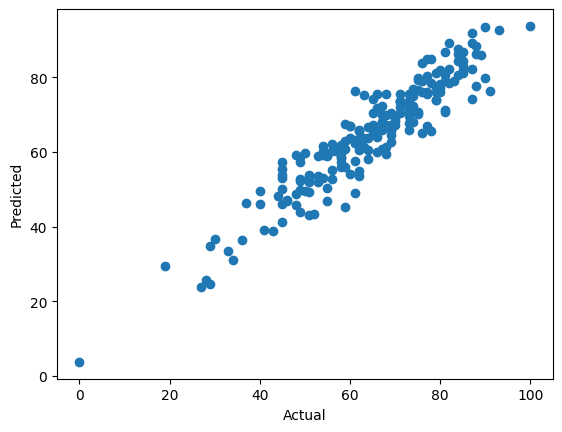

In [44]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

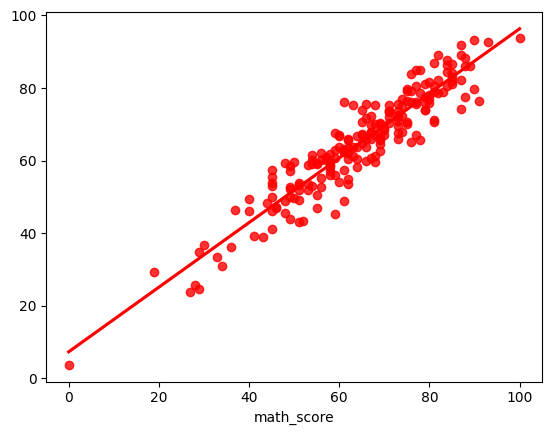

In [45]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [46]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
